In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np

# False Positives - pixel level lightcurve plot

This notebook continues with the mini-series on how to look for false positives in TESS data. In this notebookwe extact a lightcurve for each individual pixel around the target to see whether the signal is on target!

Notes:

- You need to run each cell. Do this by either pressing the 'run' button at the top of the page or pressing shift+enter (this is what Nora does in the videos). 

- When you run a cell, a star will appear in the brackets to the left of the cell while the cell is runnning. Once it has successfully completed running the code the star will turn into a number (often it runs so fast that you don't see the star).

- Text following a #, or within triple quotation marks (''') is ignored by the code (except in this cell because I made this into a text cell)


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

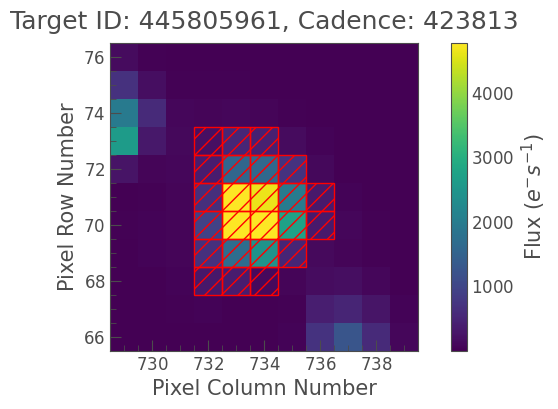

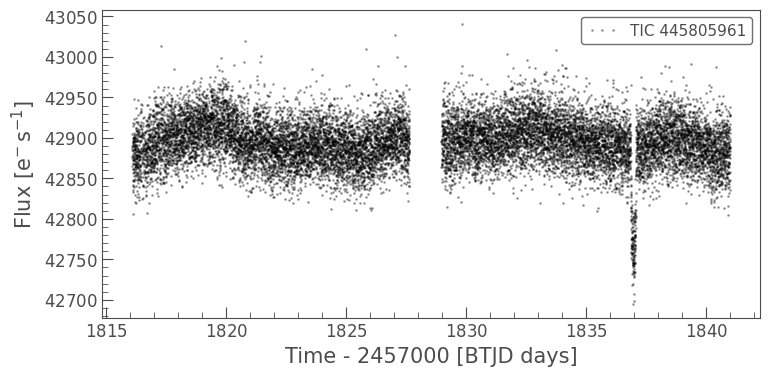

In [4]:
# download the TESS target pixel file
TIC = 'TIC 445805961' # !! CHANGE THIS to run code for a different TIC ID

# for this analysis we only want one sector of data, so user the 'sector = ' command in the line below.

search_result = lk.search_targetpixelfile(TIC, author="SPOC", sector=19) # CHANGE the sector for different targets
tpf = search_result.download()
tpf.plot(aperture_mask='pipeline')


# download the TESS lightcurve for the same sector 

sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = 19) # CHANGE the sector for different targets

lc = sector_data.download()
lc.plot(linewidth = 0, marker = '.', color = 'black', alpha = 0.3)

In [7]:
'''
This cell contains the 'function' that plots the pixel level lighcurve plot! 
You don't need to do anything with this code but you do have to RUN THIS CELL for the test to work! 
'''

def plot_pixel_level_LC(tpf, transit_time, ql = False):
    
    transit_list = [transit_time]
    t_list = [tpf.time.value]
    tpf_list = [tpf.flux.value]
    bkg_list = [np.nanmean(tpf.flux.value,axis = 0)]
    arrshape_list = [tpf.flux.shape]

    # loop through the transits and make plot for each ( only the first is currently displayed in the pdf report)
    for idx, X1_original in enumerate(tpf_list):

        bkg = np.flip(bkg_list[idx], axis = 0)
        arrshape = arrshape_list[idx]
        peak = transit_list[idx]
        tpf = tpf_list[idx]
        
        s = X1_original.shape
        X1 = X1_original.reshape(s[0],s[1]*s[2])
        
        T0 = transit_list[idx] # the time of the transit-like event
        t = t_list[idx] # the time array

        intr = abs(T0-t) < 0.25  # create a mask of the in transit times
        oot = (abs(T0-t) < 0.5) * (abs(T0-t) < 0.3)  # create a mask of the out of transit times
        

        fig, ax = plt.subplots(arrshape[1], arrshape[2], sharex = True, sharey = False, gridspec_kw={'hspace': 0 ,'wspace': 0}, figsize=(5.5,5.5))

        plt.tight_layout()

        # see if the backrgound of this plot can be the average pixel flux (if there are too many nans this will fail and the background will just be black which is also okay)
        try:
            color = plt.cm.viridis(np.linspace(0, 1,int(np.nanmax(bkg))-int(np.nanmin(bkg))+1))
            simplebkg = False
        except:
            simplebkg = True

        for i in range(0,arrshape[1]):
            ii = arrshape[1]-1-i # we want to plot this such that the pixels increase from left to right and bottom to top

            for j in range(0,arrshape[2]):

                apmask = np.zeros(arrshape[1:],  dtype=int)
                apmask[i,j] = 1
                apmask = apmask.astype(bool)
                
                flux = X1[:,apmask.flatten()].sum(axis=1)

                m = np.nanmedian(flux[oot])

                normalizedflux = flux/m

                # bin the data
                f1 = normalizedflux
                time = t


                binfac = 7

                N       = len(time)
                n       = int(np.floor(N/binfac)*binfac)
                X       = np.zeros((2,n))
                X[0,:]  = time[:n]
                X[1,:]  = f1[:n]
                Xb      = rebin(X, (2,int(n/binfac)))

                # binned data
                time_binned    =    np.array(Xb[0])
                flux_binned    =   np.array(Xb[1])

                
                # create a mask that only looks at the times cut around the transit-event
                timemask = (time_binned < peak+1.5) & (time_binned > peak-1.5)

                time_binned = time_binned[timemask]
                flux_binned = flux_binned[timemask]

                # ----------
                # fit a spline to the cut-out of each pixel LC in order to flatten it
                p = np.poly1d(np.polyfit(time_binned, flux_binned, 3))
                flux_binned = flux_binned/p(time_binned)
                # ----------

                intr = abs(peak-time_binned) < 0.1

                if simplebkg == True:
                    ax[ii, j].set_facecolor(color = 'k')
                    linecolor = 'w'
                    transitcolor = 'gold'
                else:
                    ax[ii, j].set_facecolor(color = color[int(bkg[ii,j])-int(np.nanmin(bkg))])

                    if int(bkg[ii,j])-abs(int(np.nanmin(bkg))) > ((np.nanmax(bkg))-abs(int(np.nanmin(bkg))))/2:
                        linecolor = 'k'
                        transitcolor = 'orangered'
                    else:
                        linecolor = 'w'
                        transitcolor = 'gold'


                ax[ii, j].plot(time_binned,flux_binned, color = linecolor, marker = '.', markersize=1, lw = 0)
                ax[ii, j].plot(time_binned[intr],flux_binned[intr], color = transitcolor, marker = '.', markersize=1, lw = 0)

                # get rid of ticks and ticklabels
                ax[ii,j].set_yticklabels([])
                ax[ii,j].set_xticklabels([])
                ax[ii,j].set_xticks([])
                ax[ii,j].set_yticks([])

        # ------------------

        print ("done.\n")
        # ------------------

        # label the pixels

        fig.text(0.5,0.01, "column (pixel)", ha='center', fontsize = 13)
        fig.text(0.01, 0.5, "row (pixel)", va='center', rotation='vertical', fontsize = 13)

        # - - - - - - - - - -

        plt.subplots_adjust(top=0.95, right = 0.99, bottom = 0.04, left = 0.04)

        plt.suptitle(r"T0 = {} $\pm$ 1.5 d".format(peak ),y=0.98, fontsize = 12)
        plt.xlim(peak-1.5,peak+1.5)
        plt.show()
        
        
def rebin(arr,new_shape):

    ''''
    function used to rebin the data
    '''
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
        new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)


done.



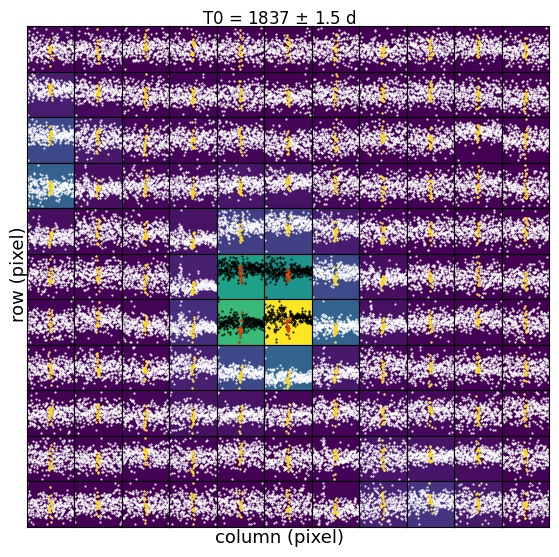

In [8]:
'''we can now use the function that was defined above to plot the test for a given target
(we'll start with the target that we already downlaoded data for above)

Okay, so for the code to work all we need to do is define the time of the transit event!

'''

transit_time = 1837

plot_pixel_level_LC(tpf, transit_time)



In this example above the transit event appears to be on the central brightest pixel - the signal is very small, and often you won't be able to see it, but the maien thing is that the signal is NOT originating from elsewhere. Bottom line is, if you can't see the signal on the central pixel, that's not a problem (as planet transits can be very tiny) - as long as we don't see any dips on other pixels we're all good! Keep going in this notebook for some false positives!

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

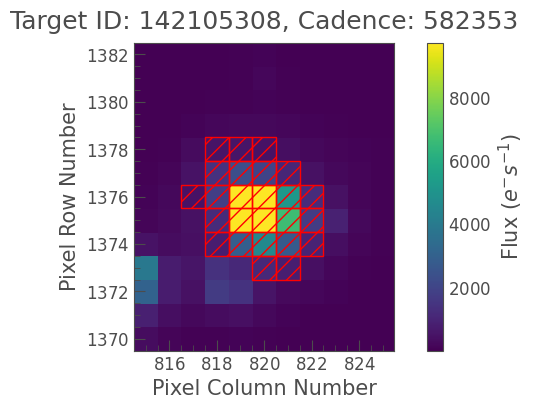

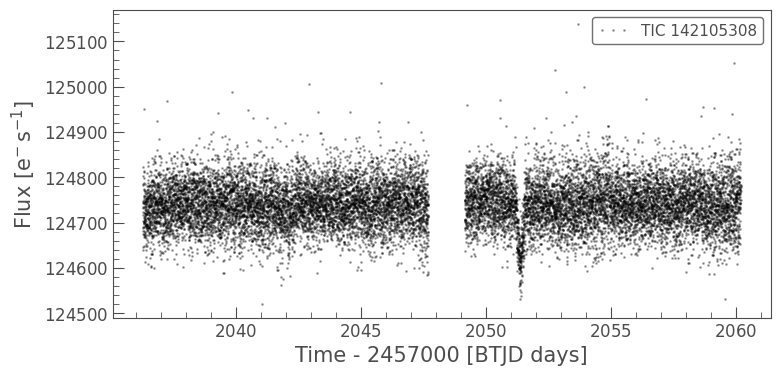

In [16]:
# download the TESS target pixel file
TIC = 'TIC 142105308' # !! CHANGE THIS to run code for a different TIC ID

search_result = lk.search_targetpixelfile(TIC, author="SPOC", sector = 27) # change the sector for different targets
tpf = search_result.download()
tpf.plot(aperture_mask='pipeline')

# download the TESS lightcurve for the same sector 
# you want to download the TESS lightcurve so that you know where the transit event is (you need this time!!)
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = 27) # change the sector for different targets

lc = sector_data.download()
lc.plot(linewidth = 0, marker = '.', color = 'black', alpha = 0.3)

done.



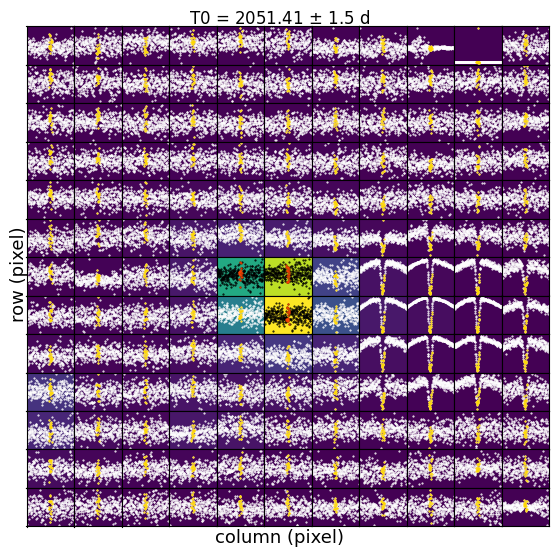

In [17]:
transit_time = 2051.41

plot_pixel_level_LC(tpf, transit_time)


The above is a great example of an eclipsing binary on a different, nearby star! Note that false positives aren't always as clear as this! This is a false positive!

<IPython.core.display.Javascript object>


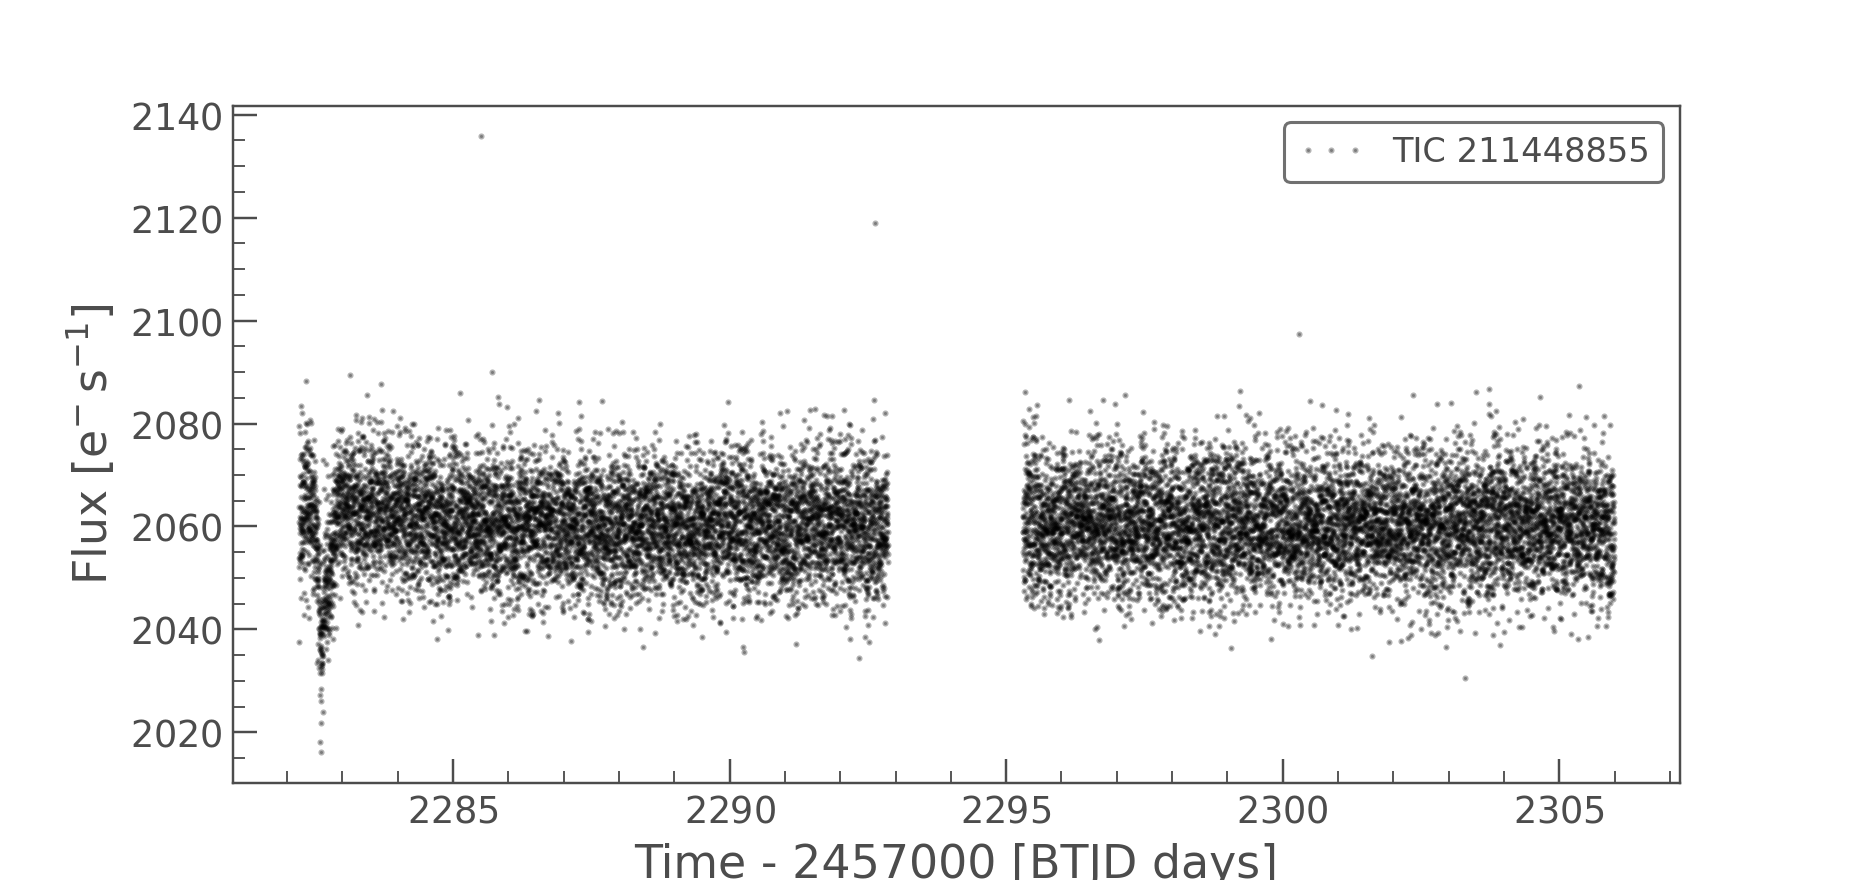

In [16]:
# download the TESS target pixel file
TIC = 'TIC 211448855' # !! CHANGE THIS to run code for a different TIC ID

search_result = lk.search_targetpixelfile(TIC, author="SPOC", sector = 36) # change the sector for different targets
tpf = search_result.download()

# download the TESS lightcurve for the same sector 
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = 36) # change the sector for different targets

lc = sector_data.download()
lc.plot(linewidth = 0, marker = '.', color = 'black', alpha = 0.3)

<IPython.core.display.Javascript object>


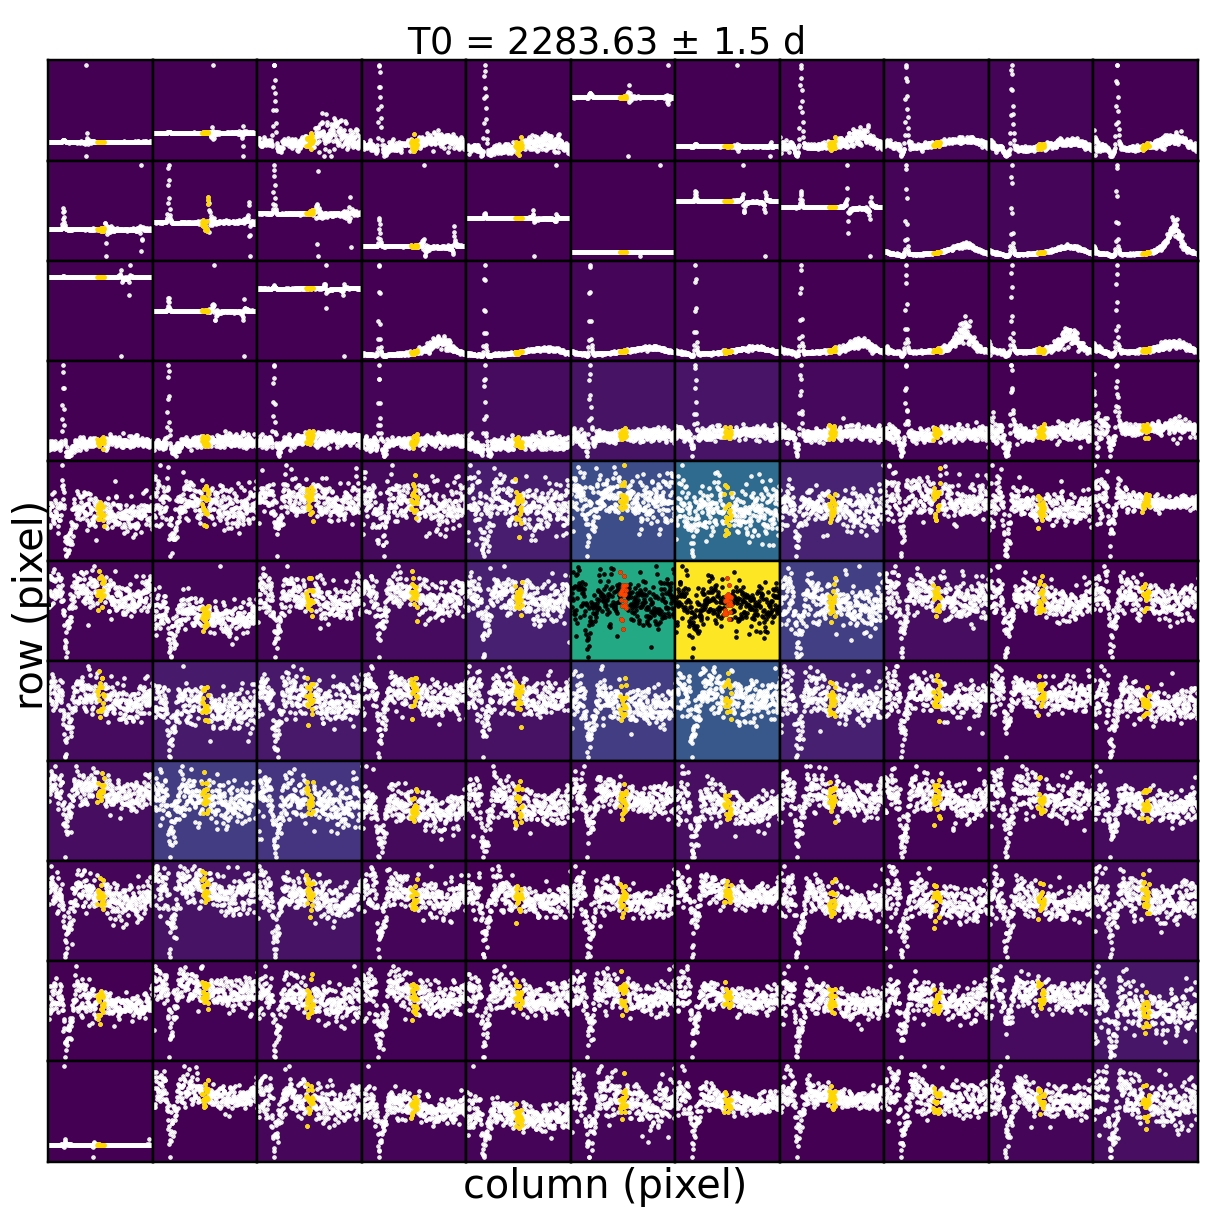

done.



In [17]:
transit_time = 2283.63

plot_pixel_level_LC(tpf, transit_time)


This above example is another false positive showing an asteroid moving through the field of view. 

Try to fill in the code below with your own target:

NOTE the below code won't run unless you fill the necessary parts!

In [ ]:
TIC = # enter TIC ID here

# replace the question marks in the line below with the sector in which the target was osberved
search_result = lk.search_targetpixelfile(TIC, author="SPOC", sector = ????) 
tpf = search_result.download()

# enter that same sector in the line below 
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = ????) 

lc = sector_data.download()
lc.plot(linewidth = 0, marker = '.', color = 'black', alpha = 0.3)

In [ ]:
transit_time = # enter the time of the transit event here

plot_pixel_level_LC(tpf, transit_time)
